# ● Libraries

In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import math
from scipy import ndimage
from skimage import data
from skimage import filters as skifilters
from skimage import img_as_float
from sklearn.cluster import KMeans, MeanShift
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage.measure import label as skilabel
from skimage.segmentation import (morphological_chan_vese,
                                  checkerboard_level_set)
from skimage.feature import local_binary_pattern
from skimage.feature.texture import greycomatrix, greycoprops
from scipy.stats import skew
from skimage.measure import label, regionprops
from scipy import interp
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import time
import seaborn as sn
import pandas as pd
import time
import tqdm
import dill
from ReliefF import ReliefF
from skimage.morphology.convex_hull import convex_hull_image

# ● Dataset

In [2]:
def sortData(path,mask=False):
    """"
    Input:  path
    Output: data[p] = {
        'id':
        'image':
        'label': }
        
    """
    # Importing Images
    B0_dir  = glob.glob(path+"/b0/*.png")
    M0_dir  = glob.glob(path+"/m0/*.png")

    print("Number of B0 Images:",  len(B0_dir))
    print("Number of M0 Images:",  len(M0_dir))
    
    # Creating Dictionary (B0 Scans)
    data = {}
    for p in range(len(B0_dir)):
        scan_id  =  B0_dir[p].replace(".png", "")
        scan_id  =  scan_id.replace(path+"/b0\\", "")

        # Creating list of dictionary                    
        data[p] = {
                    'id'    : scan_id,
                    'image' : B0_dir[p],
                    'label' : 0 }            # Label of B0 = 0

    # Creating Dictionary (M0 Scans)
    for p in range(len(M0_dir)):
        scan_id  =  M0_dir[p].replace(".png", "")
        scan_id  =  scan_id.replace(path+"/m0\\", "")

        # Creating list of dictionary                    
        data[p+len(M0_dir)] = {
                    'id'    : scan_id,
                    'image' : M0_dir[p],
                    'label' : 1 }            # Label of M0 = 1
    return data

def findScan(data,name,key):
    """"
    Input: 
        data     - dict of dict to sort the data
        key      - key of 'data' ('id','image','label')
        value    - value of 'key'
    Output:
        value
    """
    for i, dic in data.items():
        if dic[key] == name:        
            return i
    return -1

In [3]:
train_data = sortData('../data/train')           # Load Training Set

Number of B0 Images: 13108
Number of M0 Images: 13108


In [4]:
val_data   = sortData('../data/val')             # Load Validation Set

Number of B0 Images: 1639
Number of M0 Images: 1639


In [5]:
# Pass Target Image (Example)
index1  = findScan(train_data,'b_trainImage115','id')
sample1 = plt.imread(train_data[index1]['image'])
index2  = findScan(train_data,'b_trainImage111','id')
sample2 = plt.imread(train_data[index2]['image'])
index3  = findScan(train_data,'b_trainImage140','id')
sample3 = plt.imread(train_data[index3]['image'])

# ● Preprocessing

## Contrast-Limited Adaptive Histogram Equalization (CLAHE)

In [ ]:
def clahe_RGB(img,clip=3,tile=1):

    lab        = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)                          # Convert to LAB Color Space
    clahe      = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile,tile))     # Create CLAHE Function
    lab[:,:,0] = clahe.apply(lab[:,:,0])                                       # Apply Transformation
    output     = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)                          # Convert to LAB Color Space
   
    return output

def color_constant(img):
    # Extract Color Channels
    img_R = img[:,:,0]
    img_G = img[:,:,1]
    img_B = img[:,:,2]    
    
    # Calculate Channel Averages
    avg_R = np.mean(img_R)
    avg_G = np.mean(img_G)
    avg_B = np.mean(img_B)
    avg_all = np.mean(img)
    
    # Calculate Scaling Factor for White-Balance
    scale_R = (avg_all / avg_R)
    scale_G = (avg_all / avg_G)
    scale_B = (avg_all / avg_B)
    
    # Transform to White-Balance
    img_new = np.zeros(img.shape)
    img_new[:,:,0] = scale_R * img_R  
    img_new[:,:,1] = scale_G * img_G 
    img_new[:,:,2] = scale_B * img_B  
    
    # Normalize Images
    max_intensity = np.max(np.max(np.max(img_new)))
    min_intensity = np.min(np.min(np.min(img_new)))
    
    img_normalized = (((img_new - min_intensity) / (max_intensity - min_intensity))*255).astype(np.uint8)

    # Illuminant Profile (Gray World Color Constancy) 
    illuminance = [avg_R, avg_G, avg_B]
    
    return img_normalized




def white_balance(img):
    # White Balance in LAB Color Space
    result = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)                                             
    avg_a  = np.average(result[:, :, 1])
    avg_b  = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)      
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)      
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return result

## PDE-ROF Denoising

In [7]:
def denoise_RGB(img, weight=0.1, eps=1e-3, num_iter_max=200):
    op_img = img.copy()
    for channel in range(3):
        u   = np.zeros_like(img[:,:,channel])
        px  = np.zeros_like(img[:,:,channel])
        py  = np.zeros_like(img[:,:,channel])
        nm  = np.prod(img.shape[:2])
        tau = 0.125

        i = 0
        while (i < num_iter_max):
            u_old = u

            # X and Y Components of U's Gradient
            ux = np.roll(u, -1, axis=1) - u
            uy = np.roll(u, -1, axis=0) - u

            # Update Dual Variable
            px_new   = px + (tau / weight) * ux
            py_new   = py + (tau / weight) * uy
            norm_new = np.maximum(1, np.sqrt(px_new **2 + py_new ** 2))
            px       = px_new / norm_new
            py       = py_new / norm_new

            # Calculate Divergence
            rx    = np.roll(px, 1, axis=1)
            ry    = np.roll(py, 1, axis=0)
            div_p = (px - rx) + (py - ry)

            # Update Image
            u = img[:,:,channel] + weight * div_p

            # Calculate Error
            error = np.linalg.norm(u - u_old) / np.sqrt(nm)
            if i == 0:
                err_init = error
                err_prev = error
            else:
                # Break for Small Error
                if np.abs(err_prev - error) < eps * err_init:
                    break
                else:
                    e_prev = error
            i += 1    
            op_img[:,:,channel] = u

    return op_img

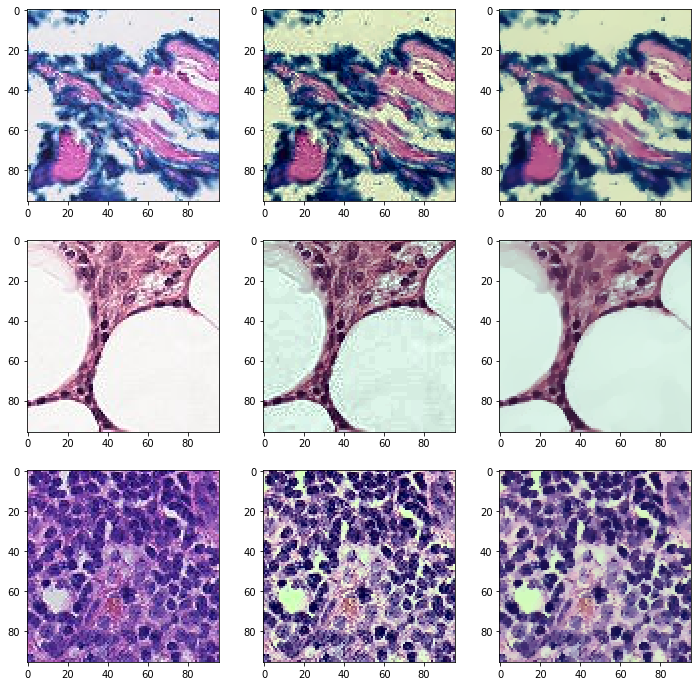

In [9]:
# CLAHE Preprocessing
cl1   = clahe_RGB(white_balance((sample1*255).astype(np.uint8)))
cl2   = clahe_RGB(white_balance((sample2*255).astype(np.uint8)))
cl3   = clahe_RGB(white_balance((sample3*255).astype(np.uint8)))

# PDE-ROF Denoising
denoi1   = denoise_RGB(cl1, weight=10)
denoi2   = denoise_RGB(cl2, weight=10)
denoi3   = denoise_RGB(cl3, weight=10)

plt.figure(figsize=[12,12])
plt.subplot(331)
plt.imshow(sample1)
plt.subplot(332)
plt.imshow(cl1)
plt.subplot(333)
plt.imshow(denoi1)
plt.subplot(334)
plt.imshow(sample2)
plt.subplot(335)
plt.imshow(cl2)
plt.subplot(336)
plt.imshow(denoi2)
plt.subplot(337)
plt.imshow(sample3)
plt.subplot(338)
plt.imshow(cl3)
plt.subplot(339)
plt.imshow(denoi3)

# ● Feature Extraction

In [135]:
def extract_features(image):
    
    # Color Spaces --------------------------------------------------------------------------------------------------
    img_RGB                 = image
    img_HSV                 = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    img_LAB                 = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Lab)
    img_YCrCb               = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    img_GL                  = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    img_luv                 = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2Luv)
      
    #----------------------------------------------------------------------------------------------------------------
    
    
    
    # Color Moments -------------------------------------------------------------------------------------------------
    mean_R = np.mean(img_RGB[:,:,0])
    mean_G = np.mean(img_RGB[:,:,1])
    mean_B = np.mean(img_RGB[:,:,2])
    std_R = np.std(img_RGB[:,:,0])
    std_G = np.std(img_RGB[:,:,1])
    std_B = np.std(img_RGB[:,:,2])
    skew_R = skew(img_RGB[:,:,0].reshape(-1))
    skew_G = skew(img_RGB[:,:,1].reshape(-1))
    skew_B = skew(img_RGB[:,:,2].reshape(-1))

    mean_H = np.mean(img_HSV[:,:,0])
    mean_S = np.mean(img_HSV[:,:,1])
    mean_V = np.mean(img_HSV[:,:,2])
    std_H = np.std(img_HSV[:,:,0])
    std_S = np.std(img_HSV[:,:,1])
    std_V = np.std(img_HSV[:,:,2])
    skew_H = skew(img_HSV[:,:,0].reshape(-1))
    skew_S = skew(img_HSV[:,:,1].reshape(-1))
    skew_V = skew(img_HSV[:,:,2].reshape(-1))

    mean_L = np.mean(img_LAB[:,:,0])
    mean_A = np.mean(img_LAB[:,:,1])
    mean_b = np.mean(img_LAB[:,:,2])
    std_L = np.std(img_LAB[:,:,0])
    std_A = np.std(img_LAB[:,:,1])
    std_b = np.std(img_LAB[:,:,2])
    skew_L = skew(img_LAB[:,:,0].reshape(-1))
    skew_A = skew(img_LAB[:,:,1].reshape(-1))
    skew_b = skew(img_LAB[:,:,2].reshape(-1))
    
    mean_Y = np.mean(img_YCrCb[:,:,0])
    mean_Cr = np.mean(img_YCrCb[:,:,1])
    mean_Cb = np.mean(img_YCrCb[:,:,2])
    std_Y = np.std(img_YCrCb[:,:,0])
    std_Cr = np.std(img_YCrCb[:,:,1])
    std_Cb = np.std(img_YCrCb[:,:,2])
    skew_Y = skew(img_YCrCb[:,:,0].reshape(-1))
    skew_Cr = skew(img_YCrCb[:,:,1].reshape(-1))
    skew_Cb = skew(img_YCrCb[:,:,2].reshape(-1))
    
    mean_l = np.mean(img_luv[:,:,0])
    mean_u = np.mean(img_luv[:,:,1])
    mean_v = np.mean(img_luv[:,:,2])
    std_l = np.std(img_luv[:,:,0])
    std_u = np.std(img_luv[:,:,1])
    std_v = np.std(img_luv[:,:,2])
    skew_l = skew(img_luv[:,:,0].reshape(-1))
    skew_u = skew(img_luv[:,:,1].reshape(-1))
    skew_v = skew(img_luv[:,:,2].reshape(-1))
    #--------------------------------------------------------------------------------------------------------------
    
    
    
    # Grey-Level Co-Occurrence Matrix -----------------------------------------------------------------------------
    GLCM_R = greycomatrix(img_RGB[:,:,0], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_G = greycomatrix(img_RGB[:,:,1], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_B = greycomatrix(img_RGB[:,:,2], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_H = greycomatrix(img_HSV[:,:,0], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_S = greycomatrix(img_HSV[:,:,1], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_V = greycomatrix(img_HSV[:,:,2], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_L = greycomatrix(img_LAB[:,:,0], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_a = greycomatrix(img_LAB[:,:,1], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    GLCM_b = greycomatrix(img_LAB[:,:,2], [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
    
    contrast_R = greycoprops(GLCM_R, 'contrast').mean()
    contrast_G = greycoprops(GLCM_G, 'contrast').mean()
    contrast_B = greycoprops(GLCM_B, 'contrast').mean()
    contrast_H = greycoprops(GLCM_H, 'contrast').mean()
    contrast_S = greycoprops(GLCM_S, 'contrast').mean()
    contrast_V = greycoprops(GLCM_V, 'contrast').mean()
    contrast_L = greycoprops(GLCM_L, 'contrast').mean()
    contrast_a = greycoprops(GLCM_a, 'contrast').mean()
    contrast_b = greycoprops(GLCM_b, 'contrast').mean()

    dissim_R = greycoprops(GLCM_R, 'dissimilarity').mean()
    dissim_G = greycoprops(GLCM_G, 'dissimilarity').mean()
    dissim_B = greycoprops(GLCM_B, 'dissimilarity').mean()
    dissim_H = greycoprops(GLCM_H, 'dissimilarity').mean()
    dissim_S = greycoprops(GLCM_S, 'dissimilarity').mean()
    dissim_V = greycoprops(GLCM_V, 'dissimilarity').mean()
    dissim_L = greycoprops(GLCM_L, 'dissimilarity').mean()
    dissim_a = greycoprops(GLCM_a, 'dissimilarity').mean()
    dissim_b = greycoprops(GLCM_b, 'dissimilarity').mean()
    
    correl_R = greycoprops(GLCM_R, 'correlation').mean()
    correl_G = greycoprops(GLCM_G, 'correlation').mean()
    correl_B = greycoprops(GLCM_B, 'correlation').mean()
    correl_H = greycoprops(GLCM_H, 'correlation').mean()
    correl_S = greycoprops(GLCM_S, 'correlation').mean()
    correl_V = greycoprops(GLCM_V, 'correlation').mean()
    correl_L = greycoprops(GLCM_L, 'correlation').mean()
    correl_a = greycoprops(GLCM_a, 'correlation').mean()
    correl_b = greycoprops(GLCM_b, 'correlation').mean()
    
    homo_R = greycoprops(GLCM_R, 'homogeneity').mean()
    homo_G = greycoprops(GLCM_G, 'homogeneity').mean()
    homo_B = greycoprops(GLCM_B, 'homogeneity').mean()
    homo_H = greycoprops(GLCM_H, 'homogeneity').mean()
    homo_S = greycoprops(GLCM_S, 'homogeneity').mean()
    homo_V = greycoprops(GLCM_V, 'homogeneity').mean()
    homo_L = greycoprops(GLCM_L, 'homogeneity').mean()
    homo_a = greycoprops(GLCM_a, 'homogeneity').mean()
    homo_b = greycoprops(GLCM_b, 'homogeneity').mean()
    #--------------------------------------------------------------------------------------------------------------
    

    
    # Local Binary Patterns --------------------------------------------------------------------------------------
    lbp       = local_binary_pattern(img_GL, P=8, R=2, method="uniform")
    lbp_GL, _ = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))

    lbp       = local_binary_pattern(img_RGB[:,:,0], P=8, R=2, method="uniform")
    lbp_R, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_RGB[:,:,1], P=8, R=2, method="uniform")
    lbp_G, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_RGB[:,:,2], P=8, R=2, method="uniform")
    lbp_B, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    
    lbp       = local_binary_pattern(img_HSV[:,:,0], P=8, R=2, method="uniform")
    lbp_H, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_HSV[:,:,1], P=8, R=2, method="uniform")
    lbp_S, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_HSV[:,:,2], P=8, R=2, method="uniform")
    lbp_V, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    
    lbp       = local_binary_pattern(img_YCrCb[:,:,0], P=8, R=2, method="uniform")
    lbp_Y, _  = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_YCrCb[:,:,1], P=8, R=2, method="uniform")
    lbp_Cr, _ = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
    lbp       = local_binary_pattern(img_YCrCb[:,:,2], P=8, R=2, method="uniform")
    lbp_Cb, _ = np.histogram(lbp, density=True, bins=10, range=(0,int(lbp.max()+1)))
       
    LBP_CGLF  = np.concatenate((lbp_R,lbp_G,lbp_B,lbp_H,lbp_S,lbp_V,lbp_Y,lbp_Cr,lbp_Cb,lbp_GL),axis=0)
    #--------------------------------------------------------------------------------------------------------------
    
    
    
    # Gabor Filter Features --------------------------------------------------------------------------------------
    gabor_energy     = []
    gabor_filters    = []
    kernel_size      = [3, 6, 9]
    thetas           = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    for size in kernel_size:
        for theta in thetas:
            kern = cv2.getGaborKernel((size,size), 10.0, theta, 10.0, 1, 1, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            gabor_filters.append(kern) 
    for kern in gabor_filters:
        fimg        = cv2.filter2D(img_GL, cv2.CV_8UC3, kern)
        gaborGLCM   = greycomatrix(fimg, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2**8)
        gabor_energy.append(greycoprops(gaborGLCM, 'energy').mean())
    #--------------------------------------------------------------------------------------------------------------
    
    
    
    # Smoothness, Uniformity, Entropy -----------------------------------------------------------------------------
    histogram_GL      = np.histogram(img_GL, bins=2**8, range=(0,(2**8)-1), density=True)
    histogram_prob_GL = histogram_GL[0]/sum(histogram_GL[0])    
    single_entropy_GL = np.zeros((len(histogram_prob_GL)), dtype = float)
    for i in range(len(histogram_prob_GL)):
        if(histogram_prob_GL[i] == 0):
            single_entropy_GL[i] = 0;
        else:
            single_entropy_GL[i] = histogram_prob_GL[i]*np.log2(histogram_prob_GL[i]);

    smoothness   = 1- 1/(1 + np.var(img_GL/2**8))            
    uniformity   = sum(histogram_prob_GL**2);        
    entropy      = -(histogram_prob_GL*single_entropy_GL).sum()
    #--------------------------------------------------------------------------------------------------------------
    
    
    
    features = [ smoothness, uniformity, entropy, mean_R, mean_G, mean_B, std_R, std_G, std_B, skew_R, skew_G, skew_B, mean_H,
                 mean_S, mean_V, std_H, std_S, std_V, skew_H, skew_S, skew_V,  mean_L, mean_A, mean_b, std_L, std_A, std_b, skew_L,
                 skew_A, skew_b, mean_Y, mean_Cr, mean_Cb, std_Y, std_Cr, std_Cb, skew_Y, skew_Cr, skew_Cb, mean_l, mean_u, 
                 mean_v, std_l, std_u, std_v, skew_l, skew_u, skew_v, contrast_R, contrast_G, contrast_B, contrast_H, contrast_S, 
                 contrast_V, contrast_L, contrast_a, contrast_b, dissim_R, dissim_G, dissim_B, dissim_H, dissim_S, dissim_V, dissim_L, 
                 dissim_a, dissim_b, correl_R, correl_G, correl_B, correl_H, correl_S, correl_V, correl_L, correl_a, correl_b, homo_R, 
                 homo_G, homo_B, homo_H, homo_S, homo_V, homo_L, homo_a, homo_b ]
 
    features = np.concatenate((features,LBP_CGLF,gabor_energy),axis=0)

    return features

In [136]:
# Feature Vector Length (Redundancy Check)
demo = np.array(extract_features(cl3))
demo.shape

(196,)

In [12]:
train_features_B0 = [] 
train_features_M0 = []

counter      = 0
start        = 0
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # Preprocessing
    cl       = clahe_RGB((image*255).astype(np.uint8))         # CLAHE Preprocessing
    denoi    = denoise_RGB(cl, weight=10)                      # PDE-ROF Denoising              
        
    # Feature Extraction
    features = extract_features(denoi)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==0):                           # B0 Features
        if (len(train_features_B0)==0):
            train_features_B0 = features
        else:
            train_features_B0 = np.concatenate((train_features_B0,features),axis=0)

    if (label==1):                           # M0 Features
        if (len(train_features_M0)==0):
            train_features_M0 = features
        else:
            train_features_M0 = np.concatenate((train_features_M0,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

100%|██████████████████████████████████████████████████████████████████████████| 26216/26216 [3:42:26<00:00,  1.94it/s]


Features Extraction (Training Set) Complete: 26216


In [13]:
val_features_B0  = [] 
val_features_M0  = []

counter      = 0
start        = 0
stop         = len(val_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(val_data[index]['image'])
    scan_id  = val_data[index]['id']
    label    = val_data[index]['label']
        
    # Preprocessing
    cl       = clahe_RGB((image*255).astype(np.uint8))         # CLAHE Preprocessing
    denoi    = denoise_RGB(cl, weight=10)                      # PDE-ROF Denoising              
        
    # Feature Extraction
    features = extract_features(denoi)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==0):                           # B0 Features
        if (len(val_features_B0)==0):
            val_features_B0 = features
        else:
            val_features_B0 = np.concatenate((val_features_B0,features),axis=0)

    if (label==1):                           # M0 Features
        if (len(val_features_M0)==0):
            val_features_M0 = features
        else:
            val_features_M0 = np.concatenate((val_features_M0,features),axis=0)
    counter = counter + 1

print("Features Extraction (Validation Set) Complete: "+str(counter))

100%|██████████████████████████████████████████████████████████████████████████████| 3278/3278 [27:54<00:00,  1.99it/s]


Features Extraction (Training Set) Complete: 3278


## Feature Selection

In [238]:
FS           = ReliefF(n_neighbors=500, n_features_to_keep=10)
X_trainFS    = FS.fit_transform(X_train, Y_train)
X_testFS     = FS.fit_transform(X_test, Y_test)

print("Feature Vector (Before) : "+str(X_train.shape)+ "\nFeature Vector (After)  : "+str(X_trainFS.shape))

Feature Vector (Before) : (4800, 202)
Feature Vector (After)  : (4800, 10)


# ● Classifier (Super Vector Machine)

## Normalization

In [14]:
def concat_and_shuffled(class0,class1, shuffled=True):
    rnd = np.random.RandomState(8)
    
    # Create Individual Label Vectors
    Y_0   = np.zeros(class0.shape[0])
    Y_1   = np.ones(class1.shape[0])
    
    # Concatenate to Complete Vectors
    Y     = np.concatenate([Y_0,Y_1])
    X     = np.concatenate([class0,class1])
    
    if shuffled:
        shuffled_indices = rnd.permutation(np.arange(Y.shape[0]))
        return X[shuffled_indices], Y[shuffled_indices]
    else:
        return X, Y

In [122]:
# Generate Randomly Shuffled Consolidated Training and Validation Vectors
X_test, Y_test              = concat_and_shuffled(class0=val_features_B0,   class1=val_features_M0,   shuffled=True)
X_train,Y_train             = concat_and_shuffled(class0=train_features_B0, class1=train_features_M0, shuffled=True)

# Normalize to Mean=0 and Standard Deviation=1 
X_train                     = (X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_test                      = (X_test-np.mean(X_test,axis=0))/np.std(X_test,axis=0)

## Model Fit

In [123]:
classifier = svm.SVC(C=10, kernel='rbf', gamma='scale', probability=True, class_weight='balanced')
classifier.fit(X_train, Y_train)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

## Grid Search

In [124]:
def SVM_gridSearch(X,Y, folds):
    C = [0.01, 0.1, 1, 10]
    K = ['linear', 'rbf']
    param_grid = {'C':C, 'kernel':K}
    grid_search = GridSearchCV(svm.SVC(gamma='scale',probability=True,class_weight='balanced'), param_grid, cv=folds)
    grid_search.fit(X,Y)
    grid_search.best_params_
    return grid_search.best_params_

SVM_gridSearch(X,Y,5)

{'C': 10, 'kernel': 'rbf'}

# ● Results (AUC, F1, Accuracy, Precision, Recall)

In [124]:
def ROC(X_test,Y_test,clf) :
    TPRS = []
    AUCS = []
    mean_FPR = np.linspace(0, 0.1, 100)
    
    FPR, TPR, thresholds = roc_curve(Y_test, classifier.predict_proba(X_test)[:,1])
    TPRS.append(interp(mean_FPR, FPR, TPR))
    TPRS[-1][0] = 0.0
    
    ROC_AUC = auc(FPR, TPR)
    AUCS.append(ROC_AUC)
    
    plt.figure(figsize=[6,5])
    plt.title("AUC = %0.5f"%ROC_AUC)
    plt.plot(FPR, TPR, lw=1, alpha=1.0)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(alpha=0.2)

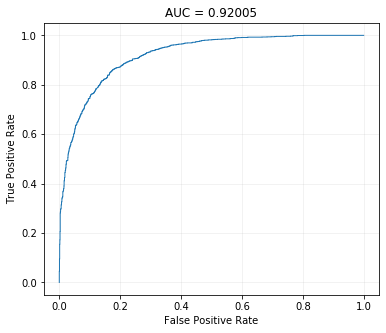

In [125]:
ROC(X_test,Y_test,classifier)

In [126]:
# Classification Metrics
accuracy  = accuracy_score(Y_test, classifier.predict(X_test))
precision = precision_score(Y_test, classifier.predict(X_test),  average="macro")
recall    = recall_score(Y_test, classifier.predict(X_test),  average="macro")
F1        = f1_score(Y_test, classifier.predict(X_test),  average="macro")

print("Accuracy = %0.4f"%accuracy)
print("Precision = %0.4f"%precision)
print("Recall = %0.4f"%recall)
print("F1 Score = %0.4f"%F1)

Accuracy = 0.8316
Precision = 0.8342
Recall = 0.8316
F1 Score = 0.8313


TN: 537
FN: 72
TP: 528
FP: 63


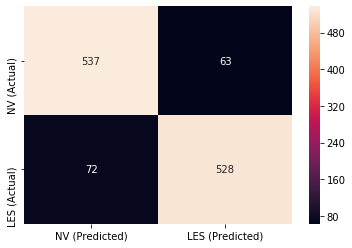

In [246]:
TN, FP, FN, TP = confusion_matrix(Y_test, classifier.predict(X_test)).ravel()
CM = confusion_matrix(Y_test, classifier.predict(X_test))
CM = pd.DataFrame(CM, index = ["M0 (Actual)","B0 (Actual)"],
                  columns = ["M0 (Predicted)","B0 (Predicted)"])
sn.heatmap(CM, annot=True, fmt='g')
print("TN: %d"%TN)
print("FN: %d"%FN)
print("TP: %d"%TP)
print("FP: %d"%FP)

## 5-Fold Cross-Validation

In [129]:
full_features_B0 = np.zeros(shape=(train_features_B0.shape[0]+val_features_B0.shape[0],train_features_B0.shape[1]))
full_features_M0 = np.zeros(shape=(train_features_M0.shape[0]+val_features_M0.shape[0],train_features_M0.shape[1]))

full_features_B0[:train_features_B0.shape[0],:] = train_features_B0
full_features_B0[train_features_B0.shape[0]:,:] = val_features_B0

full_features_M0[:train_features_M0.shape[0],:] = train_features_M0
full_features_M0[train_features_M0.shape[0]:,:] = val_features_M0

In [131]:
X, Y               = concat_and_shuffled(class0=full_features_B0, class1=full_features_M0, shuffled=True)
X                  = (X-np.mean(X,axis=0))/np.std(X,axis=0)
KFclassifier       = svm.SVC(C=10,gamma='scale',probability=True,class_weight='balanced')
scoring_metrics    = ['roc_auc', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores             = cross_validate(KFclassifier, X, Y, scoring=scoring_metrics, cv=5)

In [132]:
# Classification Metrics
print("Accuracy = %0.4f"%scores['test_accuracy'].mean())
print("Precision = %0.4f"%scores['test_precision_macro'].mean())
print("Recall = %0.4f"%scores['test_recall_macro'].mean())
print("F1 Score = %0.4f"%scores['test_f1_macro'].mean())
print("ROC(AUC) = %0.4f"%scores['test_roc_auc'].mean())

Accuracy = 0.9030
Precision = 0.9031
Recall = 0.9030
F1 Score = 0.9030
ROC(AUC) = 0.9638


# ● Visualization/Testing Features

## Gabor Filter Response

In [203]:
# Gabor Filter Features
img = cv2.cvtColor(cl3, cv2.COLOR_RGB2HSV)
img = img[:,:,:]
output_img       = []
gabor_locenergy  = []
gabor_meanamp    = []
gabor_filters    = []
kernel_size      = [3, 6, 9]
thetas           = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, 5*np.pi/8, 3*np.pi/4, 7*np.pi/8, np.pi]
for size in kernel_size:
    for theta in thetas:
        kern = cv2.getGaborKernel((size,size), 10.0, theta, 10.0, 1, 1, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        gabor_filters.append(kern) 
accum = np.zeros_like(img)
for kern in gabor_filters:
    fimg        = cv2.filter2D(img, cv2.CV_8UC3, kern)
    output_img.append(fimg)
    np.maximum(accum, fimg, accum)
gabor_filters  = np.asarray(gabor_filters)
output_img     = np.asarray(output_img)

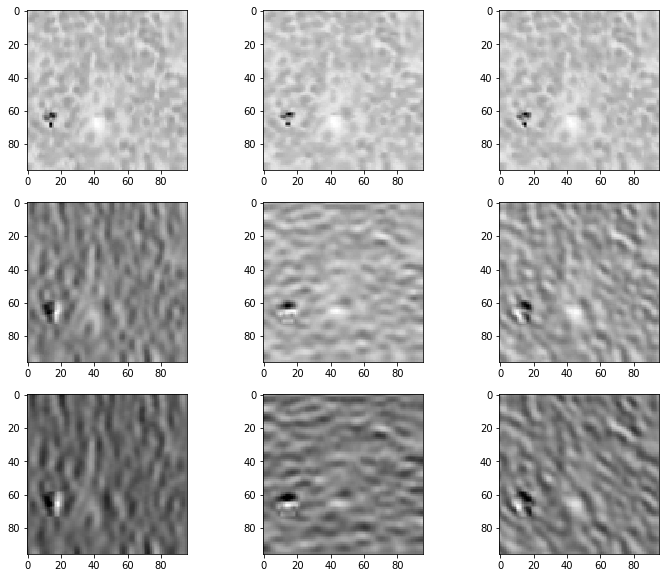

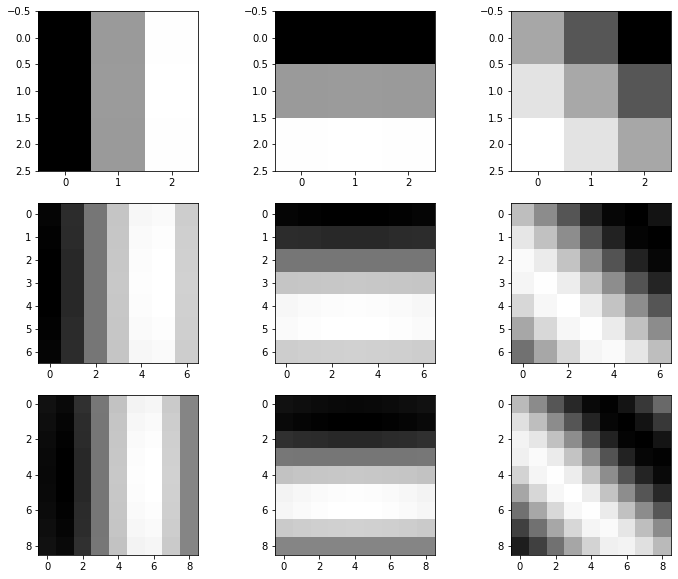

In [205]:
channel = 0

plt.figure(figsize=[12,10])
plt.subplot(331)
plt.imshow(output_img[0,:,:,channel],cmap='gray')  
plt.subplot(332)
plt.imshow(output_img[4,:,:,channel],cmap='gray')  
plt.subplot(333)
plt.imshow(output_img[6,:,:,channel],cmap='gray')  
plt.subplot(334)
plt.imshow(output_img[9,:,:,channel],cmap='gray')  
plt.subplot(335)
plt.imshow(output_img[13,:,:,channel],cmap='gray')  
plt.subplot(336)
plt.imshow(output_img[15,:,:,channel],cmap='gray')  
plt.subplot(337)
plt.imshow(output_img[18,:,:,channel],cmap='gray')  
plt.subplot(338)
plt.imshow(output_img[22,:,:,channel],cmap='gray')  
plt.subplot(339)
plt.imshow(output_img[24,:,:,channel],cmap='gray')  


plt.figure(figsize=[12,10])
plt.subplot(331)
plt.imshow(gabor_filters[0],cmap='gray')  
plt.subplot(332)
plt.imshow(gabor_filters[4],cmap='gray')  
plt.subplot(333)
plt.imshow(gabor_filters[6],cmap='gray')  
plt.subplot(334)
plt.imshow(gabor_filters[9],cmap='gray')  
plt.subplot(335)
plt.imshow(gabor_filters[13],cmap='gray')  
plt.subplot(336)
plt.imshow(gabor_filters[15],cmap='gray')  
plt.subplot(337)
plt.imshow(gabor_filters[18],cmap='gray')  
plt.subplot(338)
plt.imshow(gabor_filters[22],cmap='gray')  
plt.subplot(339)
plt.imshow(gabor_filters[24],cmap='gray')  

## ROF-PDE Denoising

In [17]:
def denoise(img, weight=0.1, eps=1e-3, num_iter_max=200):
    u   = np.zeros_like(img)
    px  = np.zeros_like(img)
    py  = np.zeros_like(img)
    nm  = np.prod(img.shape[:2])
    tau = 0.125

    i = 0
    while (i < num_iter_max):
        u_old = u

        # X and Y Components of U's Gradient
        ux = np.roll(u, -1, axis=1) - u
        uy = np.roll(u, -1, axis=0) - u

        # Update Dual Variable
        px_new   = px + (tau / weight) * ux
        py_new   = py + (tau / weight) * uy
        norm_new = np.maximum(1, np.sqrt(px_new **2 + py_new ** 2))
        px       = px_new / norm_new
        py       = py_new / norm_new

        # Calculate Divergence
        rx    = np.roll(px, 1, axis=1)
        ry    = np.roll(py, 1, axis=0)
        div_p = (px - rx) + (py - ry)

        # Update Image
        u = img + weight * div_p

        # Calculate Error
        error = np.linalg.norm(u - u_old) / np.sqrt(nm)

        if i == 0:
            err_init = error
            err_prev = error
        else:
            # Break for Small Error
            if np.abs(err_prev - error) < eps * err_init:
                break
            else:
                e_prev = error
        i += 1
    return u

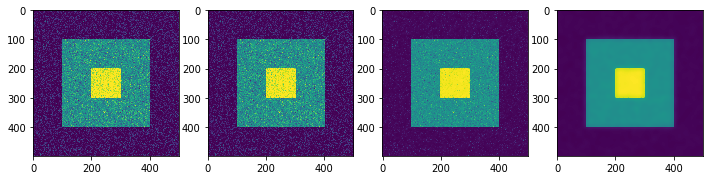

In [18]:
# Synthetic Test
img = np.zeros((500,500))
img[100:400,100:400] = 128
img[200:300,200:300] = 255
 
# Noise Addition
img = img + 30*np.random.standard_normal((500,500))
img = np.clip(img, 0, 255)

plt.figure(figsize=[12,10])
plt.subplot(141)
plt.imshow(img, cmap='viridis')
plt.subplot(142)
plt.imshow(denoise(img, weight=1), cmap='viridis')
plt.subplot(143)
plt.imshow(denoise(img, weight=10), cmap='viridis')
plt.subplot(144)
plt.imshow(denoise(img, weight=100), cmap='viridis')